In [815]:
import os

proj_dir = '/Users/nickbachelder/Desktop/Kaggle/Linemen'
os.chdir( os.path.join(proj_dir, 'code/objects') )

%run load_modules.ipynb
%run tracking_objects.ipynb

In [775]:
data_dir = os.path.join(proj_dir, 'data' )
os.chdir( proj_dir )
os.system("rm -rf {}".format( data_dir ))
os.system('mkdir data')
os.chdir( data_dir )
os.system("kaggle competitions download -c nfl-big-data-bowl-2023")
os.system( 'unzip {}.zip'.format( os.path.join(data_dir, 'nfl-big-data-bowl-2023')) )

curr_cd = os.getcwd()
files = [x for x in os.listdir(curr_cd) if os.path.isfile(os.path.join(curr_cd, x))]

player_files = [os.path.join(curr_cd, x) for x in files if x.endswith('players.csv')]
player_tracking_files = [os.path.join(curr_cd, x) for x in files if x.startswith('week')]
play_details_files = [os.path.join(curr_cd, x) for x in files if x.endswith('ScoutingData.csv')]
play_info_files = [os.path.join(curr_cd, x) for x in files if x.endswith('plays.csv')]


100%|██████████| 172M/172M [00:43<00:00, 4.20MB/s] 



Archive:  /Users/nickbachelder/Desktop/Kaggle/Linemen/data/nfl-big-data-bowl-2023.zip
  inflating: games.csv               
  inflating: pffScoutingData.csv     
  inflating: players.csv             
  inflating: plays.csv               
  inflating: week1.csv               
  inflating: week2.csv               
  inflating: week3.csv               
  inflating: week4.csv               
  inflating: week5.csv               
  inflating: week6.csv               
  inflating: week7.csv               
  inflating: week8.csv               


In [816]:
all_data = master_track(track_paths = player_tracking_files, 
                            play_info_path = play_info_files[0],
                            play_details_path = play_details_files[0],
                            players_path = player_files[0])

In [817]:
all_data.load_training_data(week = 3)

Getting week 1 training data


100%|██████████| 1172/1172 [06:03<00:00,  3.22it/s]


Getting week 2 training data


100%|██████████| 1062/1062 [05:35<00:00,  3.17it/s]


Done


In [818]:
all_data.get_averages_up_to_week(week = 3)

Getting week 1 average metrics by position and blocker number
Getting week 2 average metrics by position and blocker number
Done


In [ ]:
# figure out where these issues are coming from later and fix

all_dat_labels = all_data.get_rush_sequences_labels(week = 2, normalize = True)

training_dat, test_dat = train_test_split(all_dat_labels, test_size = 0.2)

# remove nas (fix these nas being created later)
bad_indexs = []
print('Train NA')
for value in range(len(training_dat)):
    any_na = training_dat[value][0].isnull().values.any()
    if any_na == True:
        bad_indexs.append(value)
        print(value)

for index in sorted(bad_indexs, reverse=True):
    del training_dat[index]


bad_indexs = []
print('Test NA')
for value in range(len(test_dat)):
    any_na = test_dat[value][0].isnull().values.any()
    if any_na == True:
        bad_indexs.append(value)
        print(value)

for index in sorted(bad_indexs, reverse=True):
    del test_dat[index]

print(f'Length train : {len(training_dat)}')
print(f'Length test : {len(test_dat)}')

In [821]:
# model building

model = SequenceModel(n_features = training_dat[0][0].shape[1], n_classes = 2, n_hidden = 15, n_layers = 1)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_dataset = RushDataset(sequences = training_dat, sequence_length=30)
train_loader = DataLoader(train_dataset, batch_size = 30, shuffle = True)
test_dataset = RushDataset(sequences = test_dat, sequence_length=30)
test_loader = DataLoader(test_dataset, batch_size = 30, shuffle = True)

lstm_model = train_rush_lstm(train_loader, test_loader, model, loss_function, optimizer, num_epochs = 20)

Epoch 0
---------
Overall Train loss: 0.670867657288909 , Overall Train AUC: 0.464750780996136
Train loss for period 1: 0.6704177875071764 , Train AUC for period 1: 0.4702223787967995
Train loss for period 2: 0.6711292583495378 , Train AUC for period 2: 0.4695461696603511
Train loss for period 3: 0.6713026016950607 , Train AUC for period 3: 0.4680642234598048
Train loss for period 4: 0.671387167647481 , Train AUC for period 4: 0.4675595278311311
Train loss for period 5: 0.6708110123872757 , Train AUC for period 5: 0.46031860781607414
Train loss for period 6: 0.67015815153718 , Train AUC for period 6: 0.45354329340681615
Overall test loss: 0.6460421830415726 , Overall test AUC: 0.5540354400056366
Test loss for period 1: 17.424545992165804 , Test AUC for period 1: 0.5265105032221391
Test loss for period 2: 17.44692675769329 , Test AUC for period 2: 0.5350862789842775
Test loss for period 3: 17.326089445501566 , Test AUC for period 3: 0.5529847067307296
Test loss for period 4: 17.19758083

In [1089]:
play_id = 2021091201901
player_id = 47792

all_data.replace_player_with_average(play_id = play_id, player_id = player_id)

AttributeError: 'DataFrame' object has no attribute 'nflId'

In [1063]:
### plotting all below


play_id = 2021091201901

play_prob = predict_play(master_track = all_data, week = 3, play_id = play_id, model = lstm_model, normalize = True)

player_ids = all_data.search_track_weeks(variables = ["playId"], variable_values = [play_id]).reset_index(drop = True).nflId.unique()
player_ids = np.intersect1d(player_ids, all_data.all_linemen).tolist()

rusher_play_info = all_data.get_play(play_id).reset_index()
rusher_play_info = rusher_play_info.loc[rusher_play_info.nflId.isin(player_ids)]


def_match = all_data.play_details_df.loc[(all_data.play_details_df.playId == play_id) & (all_data.play_details_df.pff_nflIdBlockedPlayer.notna()), ['playId', 'nflId', 'pff_nflIdBlockedPlayer']]
defender_track = []
for defender in def_match.nflId:
    this_def = all_data.search_track_weeks(variables = ["playId", "nflId"], variable_values = [play_id, defender])
    defender_track.append(this_def)
defender_track = pd.concat(defender_track).merge(def_match, on = ['playId', 'nflId'], how = 'left').loc[:,['nflId', 'playId', 'time_after_snap', 'pff_nflIdBlockedPlayer', 'x', 'y']].rename(columns = {'pff_nflIdBlockedPlayer' : 'nflId', 'nflId' : 'blockerId', 'x' : 'x_block', 'y' : 'y_block'})

# get qb track
qb_track = all_data.get_qb_track_on_play(play_id).loc[:, ['playId', 'time_after_snap', 'x', 'y', 's', 'a']].rename(columns = {'x' : 'x_qb', 'y' : 'y_qb', 's' : 's_qb', 'a' : 'a_qb'})
defender_qb_track = defender_track.merge(qb_track, on = ['playId', 'time_after_snap'], how = 'left')

block_df = defender_qb_track.loc[(defender_qb_track.time_after_snap >= 0) & (defender_qb_track.time_after_snap < len(play_prob) / 10), ['blockerId', 'time_after_snap', 'x_block', 'y_block']].rename(columns = {'blockerId' : 'nflId', 'x_block' : 'x', 'y_block' : 'y'}).drop_duplicates()
rush_df = rusher_play_info.loc[(rusher_play_info.time_after_snap >= 0) & (rusher_play_info.time_after_snap < len(play_prob) / 10), ['nflId', 'time_after_snap', 'x', 'y']].drop_duplicates()
qb_df = defender_qb_track.loc[(defender_qb_track.time_after_snap >= 0) & (defender_qb_track.time_after_snap < len(play_prob) / 10), ['time_after_snap', 'x_qb', 'y_qb']].rename(columns = {'x_qb' : 'x', 'y_qb' : 'y'}).drop_duplicates()
qb_df['nflId'] = 1

unique_time_after_snap = rush_df.time_after_snap.unique()
n_player_rush = len(rush_df.nflId.unique())
n_player_block = len(block_df.nflId.unique())

n_frame = len(unique_time_after_snap)
motion_rush = np.empty(shape = (n_frame,3,n_player_rush))
motion_block = np.empty(shape = (n_frame,3,n_player_block))
motion_qb = np.empty(shape = (n_frame,3, 1))
frame = 0
for time_after in unique_time_after_snap:
    this_frame_rush = rush_df.loc[rush_df.time_after_snap == time_after].copy()
    x_this_frame_rush, y_this_frame_rush, color_this_frame_rush = this_frame_rush.x.values.tolist(), this_frame_rush.y.values.tolist(), this_frame_rush.x.values.tolist()
    motion_rush[frame, :, :] = [x_this_frame_rush, y_this_frame_rush, color_this_frame_rush]
    
    this_frame_block = block_df.loc[block_df.time_after_snap == time_after].copy()
    x_this_frame_block, y_this_frame_block, color_this_frame_block = this_frame_block.x.values.tolist(), this_frame_block.y.values.tolist(), this_frame_block.x.values.tolist()
    motion_block[frame, :, :] = [x_this_frame_block, y_this_frame_block, color_this_frame_block]

    this_frame_qb = qb_df.loc[block_df.time_after_snap == time_after].copy()
    x_this_frame_qb, y_this_frame_qb, color_this_frame_qb = this_frame_qb.x.values.tolist(), this_frame_qb.y.values.tolist(), this_frame_qb.x.values.tolist()
    motion_qb[frame, :, :] = [x_this_frame_qb, y_this_frame_qb, color_this_frame_qb]

    frame += 1

Getting week 1 normalized training data
Getting week 2 normalized training data


100%|██████████| 1/1 [00:00<00:00, 381.23it/s]


In [1086]:
range_x = [min(motion_block[0,0,:]) - 15, max(motion_rush[0,0,:]) + 15]
range_y = [min(motion_rush[0,1,:]) - 15, max(motion_rush[0,1,:]) + 15]
color_min, color_max = np.amin(motion_rush[:,2,:]), np.amax(motion_rush[:,2,:])
start_frame = [go.Scatter(x=motion_rush[0,0,:], y = motion_rush[0,1,:], 
                            mode = "markers+text", 
                            text = ['QB Distruption Probability: ' + str(round(play_prob[0], 3))],
                            textposition="bottom center",
                            name = "Rushers",
                            legendgroup = "Rushers",
                            marker = dict(size=16,color=motion_rush[0,2,:],colorscale='Greens',showscale=True, cmin=color_min, cmax = color_max)),
               go.Scatter(x=motion_block[0,0,:], y = motion_block[0,1,:], 
                            mode = "markers", 
                            name = "Blockers",
                            legendgroup = "Blockers",
                            marker = dict(size=16),
                            marker_symbol = "x"  ),
                go.Scatter(x=motion_qb[0,0,:], y = motion_qb[0,1,:], 
                            mode = "markers", 
                            name = "QB",
                            legendgroup = "QB",
                            marker = dict(size=16),
                            marker_symbol = "x"  ),
                go.Scatter(x= np.array(range_x[1]-8), y = np.array(range_y[1]-3), 
                            mode = "text",
                            text = ['QB Distruption Probability: ' + str(round(play_prob[0], 3))],
                            textfont = dict(size=20) ) ]

all_frame = [   go.Frame(data = [go.Scatter(x=vec[0][0], y = vec[0][1], 
                                            mode = "markers+text", 
                                            text = 'QB Distruption Probability: ' + str(round(vec[3], 3)),
                                            textposition="bottom center",
                                            name = "Rushers",
                                            legendgroup = "Rushers",
                                            marker = dict(size=16,color=vec[0][2] ) ),
                                 go.Scatter(x=vec[1][0], y = vec[1][1], 
                                            mode = "markers", 
                                            name = "Blockers",
                                            legendgroup = "Blockers",
                                            marker = dict(size=16),
                                            marker_symbol = "x" ),
                                go.Scatter(x=vec[2][0], y = vec[2][1], 
                                            mode = "markers", 
                                            name = "QB",
                                            legendgroup = "QB",
                                            marker = dict(size=16),
                                            marker_symbol = "x" ),
                                go.Scatter(x= np.array(range_x[1]-8), y = np.array(range_y[1]-3), 
                                                mode = "text",
                                                text = ['QB Distruption Probability: ' + str(round(vec[3], 3))],
                                                ) ]) 
            for vec in zip(motion_rush[1:,:,:], motion_block[1:,:,:], motion_qb[1:,:,:], play_prob[1:])  ]
layout_draw = go.Layout(
        xaxis=dict(range=range_x, autorange=False),
        yaxis=dict(range=range_y, autorange=False),
        title= f'Play {play_id}',
        updatemenus=[dict(type="buttons",
                        buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None, {"frame": {"duration": 200, "redraw": False}, "fromcurrent": True, "transition": {"duration": 0}}])])]
    )


In [1087]:
from __future__ import annotations
import plotly
import plotly.graph_objects as go
fig = go.Figure(
    data= start_frame,
    layout=layout_draw,
    frames=all_frame
)

fig.update_layout(legend=dict(orientation = "h"))  
fig.show()

In [1040]:
list(zip(motion_rush[1:,:,:], motion_block[1:,:,:], motion_qb[1:,:,:], play_prob[1:]))[0][3]

0.28772175312042236

In [1099]:
all_data.get_play_train(play_id, type = 'individual', time_split = False)

1

In [396]:
play_dets = all_data.play_details_df
play_dets['disrupt'] = play_dets.pff_hit + play_dets.pff_hurry + play_dets.pff_sack
print( f'Percent of player play disruptions: {play_dets.disrupt.sum() / len(play_dets.disrupt)}')
team_dets = play_dets.groupby('playId').agg({'disrupt' : [sum]})
team_dets.columns = ["_".join(x) for x in np.array(team_dets.columns).ravel()]
team_dets = team_dets.reset_index()
print( f'Percent of team play disruptions: {len(team_dets.loc[team_dets.disrupt_sum > 0]) / len(team_dets)}')

Percent of player play disruptions: 0.022958343514613237
Percent of team play disruptions: 0.37583265163024426


In [ ]:
# sack / hurry / hit are dependent on both pass coverage and lineman and we only care about linemen. 
# Instead of using sack / hit /hurry, use P(Sack, Hurry, Hit @ time t) given conditions for team
# to evaluate players, need some sort of metric for 'contribution to P(Sack, Hurry, Hit @ time t) on play'
# to do so try to do  or sommin    [ P(Sack, Hurry, Hit @ time t replacing player with rusher average) / P(Sack, Hurry, Hit @ time t) ] - P(Sack, Hurry, Hit @ time t)




# new idea: since there is no team level time of sack
# find model that we can track each player prob of hit/hurry/sack 
# each player route will have a prob of sack at time t. 
# to compare use average route stats in similar situation: note may have to import more data (ie. play type etc)


# also: need to create qb_metric for 'facing rusher' 

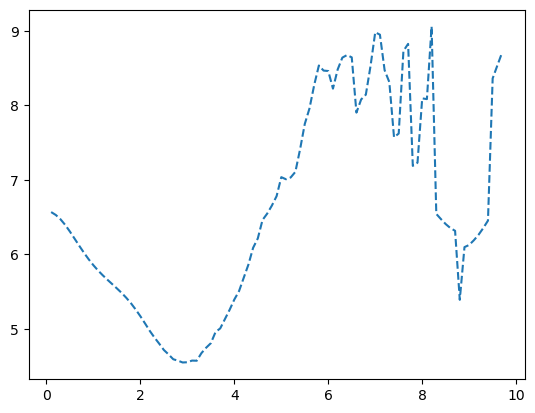

In [1205]:
import matplotlib.pyplot as plt
plot_overall_avgs = all_dist_dfs.query("time_after_snap > 0").groupby(by = ['time_after_snap']).mean().reset_index()

plt.title = "Average Rusher Distance From QB by Seconds After Snap"
plt.xlabel = "Seconds After Snap"
plt.plot('time_after_snap',  'rusher_distance_from_qb', data = plot_overall_avgs, linestyle='dashed')
plt.ylabel = "Rusher Distance From QB"
plt.show()

In [ ]:
### want to get groups of players with similar starting positions: conlusion: just use number of blockers on play for now, maybe add in weigt of blocker later

# this_week_starting_pos = all_data.training_data_individual.get('1')
# this_week_starting_pos = this_week_training_individual.loc[this_week_training_individual.time_after_snap == 0, ['playId', 'nflId', 'rusher_distance_from_qb', 'y']]



# gmm_train = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1)
# gmm = mixture.GaussianMixture(n_components=2).fit(gmm_train)
# gmm_labels = gmm.predict(gmm_train).astype(str)

# this_week_starting_pos['starting_pos_class'] = gmm_labels
# this_week_starting_pos.groupby('starting_pos_class').groups.items()
# plot_df = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1).reset_index(drop = 1)
# plot_df.starting_pos_class.unique()
# plot_df

# groups = plot_df.groupby('starting_pos_class')
# # Plot
# fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in groups:
#     ax.plot(group.rusher_distance_from_qb, group.y, marker='o', linestyle='', ms=12, label=name)
# ax.legend()

# plt.show()

# ret_df = this_week_starting_pos.loc[:, ['playId', 'nflId', 'starting_pos_class']]
# ret_df